# Lyrics Emotions Project

## Our Data

Before doing anything with data, we need to import the necessary libraries to read and manipulate the data.

In [0]:
import pandas as pd

In [0]:
single_label = pd.read_csv('SingleLabel.csv', encoding='utf-8')
single_label.head()

artist  ...       label
0         Nirvana  ...     Sadness
1   Damian Marley  ...     Tension
2  The Mission UK  ...  Tenderness
3            UB40  ...     Sadness
4     Johnny Cash  ...     Sadness

[5 rows x 7 columns]

The above dataset contains several headers that give us information on the collected songs, such as the artist, genre, title, etc. The final column, "label", along with the "lyrics" column is to be used for the Classification problem.

## Data Exploration and Preprocessing

Let's take a look at the classes distribution, before transforming the data to model-interpretable format.

In [0]:
single_label['label'].value_counts()

Sadness       569
Tenderness    326
Tension       265
Name: label, dtype: int64

Sadness is the most represented class, with Tenderness and Tension following. The dataset is imbalanced.

Next we plot the word cloud of the top 100 words in each class.

In [0]:
from wordcloud import WordCloud, STOPWORDS
sadness = single_label.loc[single_label['label']=="Sadness"]
tension = single_label.loc[single_label['label']=="Tension"]
tenderness = single_label.loc[single_label['label']=="Tenderness"]
sadness_wordcloud = WordCloud(
    width = 300,
    height = 300,
    max_words=100,
    background_color = 'white',
    stopwords = STOPWORDS).generate(" ".join(sadness['lyrics']))
sadness_wordcloud.to_file("sadness.png")

tension_wordcloud = WordCloud(
    width = 300,
    height = 300,
    max_words=100,
    background_color = 'white',
    stopwords = STOPWORDS).generate(" ".join(tension['lyrics']))
tension_wordcloud.to_file("tension.png")

tenderness_wordcloud = WordCloud(
    width = 300,
    height = 300,
    max_words=100,
    background_color = 'white',
    stopwords = STOPWORDS).generate(" ".join(tenderness['lyrics']))
tenderness_wordcloud.to_file("tenderness.png")

The word clouds show that there is a significant overlap of top words among classes.

## A: Single-Label Classification

First we import the necessary libraries

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

We had observed that the dataset is imbalanced. Conventional algorithms tend to be biased towards the majority class incase of imbalanced dataset. We will deal with this issue by applying both undersampling and oversampling techniques. 

In [0]:
sadness = sadness.sample(n = 265)
tenderness = tenderness.sample(n = 265)
single_label_under_sampled = pd.concat([sadness.sample(n=265), tenderness.sample(n=265), tension])
single_label_over_sampled =  pd.concat([sadness, pd.concat([tenderness.sample(n=243), tenderness]), pd.concat([tension.sample(n=304, replace = True), tension])])

After importing the neccessary libraries, we split the data in X and y (the "lyrics" data and the "label" data) for both under sampled and over sampled

In [0]:
X = single_label['lyrics']
X_under_sampled = single_label_under_sampled['lyrics']
X_over_sampled = single_label_over_sampled['lyrics']

In [0]:
y = single_label['label']
y_under_sampled = single_label_under_sampled['label']
y_over_sampled = single_label_over_sampled['label']

We then define our classifier as a Multi-Layer Perceptron and create a pipeline that first transforms the data and then feeds it into the Machine Learning classifier.

In [0]:
clf = MLPClassifier(random_state=1,
                    max_iter = 1000,
                    activation = 'relu',
                    solver = 'adam',
                    hidden_layer_sizes = (100,100,100,100),
                    learning_rate = 'adaptive')

Raw text data needs to be converted to feature vectors for the classifier algorithms to work. We convert the lyrics into features in two different ways and perform the classification seperately for each of them.

*   Count Vectorizer    
*   TF/IDF Vectorizer



###  Count Vectorizer
We setup a Count Vectorizer to convert our lyrics into features.


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=3,
                    max_features = 3000,
                    strip_accents='unicode',
                    lowercase = True,
                    analyzer = 'word', 
                    token_pattern=r'\w{3,}',
                    ngram_range=(1,1),
                    stop_words = "english")    

Now that we have both the classifier and vectorizer, we define a function that will do the following

1.   Setup pipeline
2.   Fit the training data
3.   Produce a classification report



In [0]:
def mlp_classification(X_train, y_train, X_test, y_test, vectorizer_):
  clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64),
                    max_iter=2000,
                    activation = 'relu',
                    solver='adam',
                    random_state=1)
  pipeline = make_pipeline(vectorizer_, clf)
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  print('ACCURACY :', accuracy_score(y_pred, y_test))
  print('REPORT :', classification_report(y_pred, y_test))
  return y_pred

Now, that we have our model, we split into training and test sets to calculate our classifier's efficiency in classifying lyrics into one of the three emotion classes.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
X_under_sampled_train, X_under_sampled_test, y_under_sampled_train, y_under_sampled_test = train_test_split(X_under_sampled, y_under_sampled, test_size=0.25, random_state = 42)
X_over_sampled_train, X_over_sampled_test, y_over_sampled_train, y_over_sampled_test = train_test_split(X_over_sampled, y_over_sampled, test_size=0.25, random_state = 42)

Finally, we fit our model with the training data and validate it on our test data. The metrics used are overall accuracy and precision, recall and f1-score for each class.

In [0]:
y_pred = mlp_classification(X_under_sampled_train, y_under_sampled_train,X_under_sampled_test, y_under_sampled_test, cv)

ACCURACY : 0.5376884422110553
REPORT :               precision    recall  f1-score   support

     Sadness       0.39      0.43      0.41        56
  Tenderness       0.70      0.61      0.65        76
     Tension       0.51      0.55      0.53        67

    accuracy                           0.54       199
   macro avg       0.53      0.53      0.53       199
weighted avg       0.55      0.54      0.54       199



We perform the same steps but with oversampled data.

In [0]:
y_pred = mlp_classification(X_over_sampled_train, y_over_sampled_train,X_over_sampled_test, y_over_sampled_test, cv)

ACCURACY : 0.8095238095238095
REPORT :               precision    recall  f1-score   support

     Sadness       0.43      0.60      0.50        43
  Tenderness       0.88      0.86      0.87       139
     Tension       0.91      0.82      0.86       154

    accuracy                           0.81       336
   macro avg       0.74      0.76      0.74       336
weighted avg       0.84      0.81      0.82       336



We perform cross validation with the best dataset to ensure that our model does not overfit and generalizes well to new data.

In [0]:
from sklearn.model_selection import cross_val_score
clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64),
                  max_iter=1000,
                  activation = 'relu',
                  solver='adam',
                  random_state=1)
pipeline = make_pipeline(cv, clf)
scores = cross_val_score(pipeline, X_over_sampled, y_over_sampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.07)


### TF/IDF Vectorizer
We set up a TF/IDF Vectorizer to transform our lyrics into features that indicate their belonging to one of the three classes.

In [0]:
tfv = TfidfVectorizer(min_df=3,
                      max_features=3000,
                      strip_accents='unicode',
                      lowercase =True,
                      analyzer='word',
                      token_pattern=r'\w{3,}',
                      ngram_range=(1,1),
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=True,
                      stop_words = "english")

We repeat the same steps we performed with Count Vectorizer with just a small change of the vectorizer.

In [0]:
y_pred = mlp_classification(X_train, y_train, X_test, y_test, tfv)

ACCURACY : 0.5793103448275863
REPORT :               precision    recall  f1-score   support

     Sadness       0.74      0.60      0.66       186
  Tenderness       0.41      0.62      0.49        55
     Tension       0.40      0.47      0.43        49

    accuracy                           0.58       290
   macro avg       0.52      0.56      0.53       290
weighted avg       0.62      0.58      0.59       290



We plot the Confusion matrix to see which classes are confused the most.

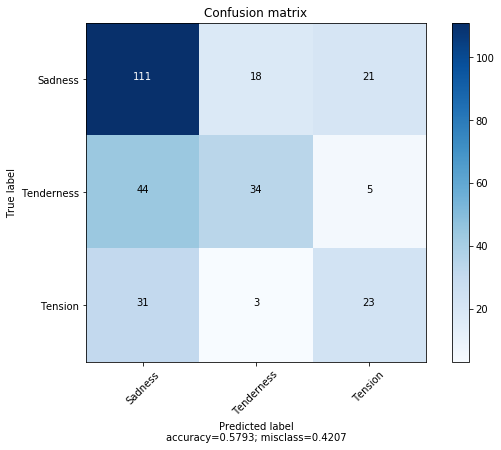

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['Sadness', 'Tenderness', 'Tension']

#Citation : https://stackoverflow.com/a/50386871/3215142
def plot_confusion_matrix(file_name,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    https://stackoverflow.com/a/50386871/3215142
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(file_name)
cm = confusion_matrix(y_test, y_pred, labels)
plot_confusion_matrix("mlp_tfv_confusion_matrix.png", cm, labels, cmap = plt.cm.Blues, normalize = False)    

We repeat the above steps for under sampled data

In [0]:
y_pred = mlp_classification(X_under_sampled_train, y_under_sampled_train,X_under_sampled_test, y_under_sampled_test, tfv)

ACCURACY : 0.5326633165829145
REPORT :               precision    recall  f1-score   support

     Sadness       0.48      0.36      0.41        80
  Tenderness       0.58      0.68      0.62        56
     Tension       0.54      0.62      0.58        63

    accuracy                           0.53       199
   macro avg       0.53      0.55      0.54       199
weighted avg       0.52      0.53      0.52       199



We plot the Confusion matrix to see which classes are confused the most.

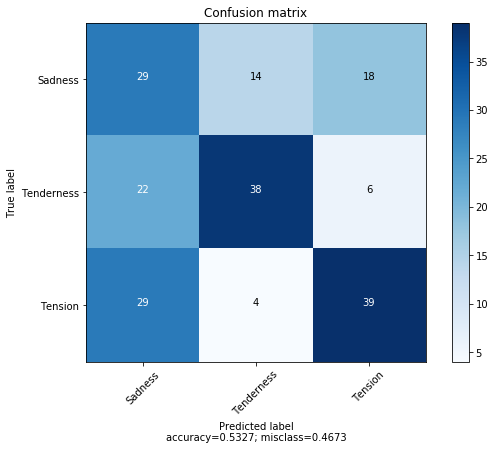

In [0]:
cm = confusion_matrix(y_under_sampled_test, y_pred, labels)
plot_confusion_matrix("mlp_tfv_under_sampled_confusion_matrix.png", cm, labels, cmap = plt.cm.Blues, normalize = False)

We perform the same steps but with over sampled data.

In [0]:
y_pred = mlp_classification(X_over_sampled_train, y_over_sampled_train,X_over_sampled_test, y_over_sampled_test, tfv)

ACCURACY : 0.8184523809523809
REPORT :               precision    recall  f1-score   support

     Sadness       0.39      0.67      0.49        36
  Tenderness       0.93      0.83      0.88       153
     Tension       0.90      0.84      0.87       147

    accuracy                           0.82       336
   macro avg       0.74      0.78      0.75       336
weighted avg       0.86      0.82      0.83       336



We plot the Confusion matrix to see which classes are confused the most.

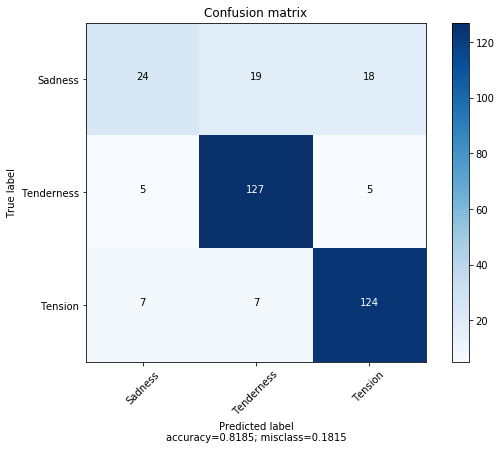

In [0]:
cm = confusion_matrix(y_over_sampled_test, y_pred, labels)
plot_confusion_matrix("mlp_tfv_over_sampled_confusion_matrix.png", cm, labels, cmap = plt.cm.Blues, normalize = False)


Now we perform cross validation to ensure that our model does not overfit and generalizes well to new data.

In [0]:
from sklearn.model_selection import cross_val_score
clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64),
                  max_iter=1000,
                  activation = 'relu',
                  solver='adam',
                  random_state=1)
pipeline = make_pipeline(tfv, clf)
scores = cross_val_score(pipeline, X_over_sampled, y_over_sampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.08)
